# 04 Building Model using Food101

Since FoodVision Mini is trained on pizza, steak and sushi images from the Food101 dataset (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

We'll go from three classes to 101!

## 1 Creating a model and transforms for FoodVision Big

In [2]:
import sys
from pathlib import Path

In [8]:
path = Path().resolve().parent
print("Root Path: ", path)
sys.path.append(str(path))

Root Path:  /Users/rahulsaini/Documents/Repositories/pytorch-foodvision-101


In [9]:
from src.modeling.models import create_effnetb2_model

In [10]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

## 2. Data Agumentation and Transforms

In [11]:
import torchvision

# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.TrivialAugmentWide(),
        effnetb2_transforms,
    ]
)


In [12]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


## 3. Getting Data for FoodVision 101

In [13]:
from torchvision import datasets

# Setup data directory
from pathlib import Path

data_dir = Path("../data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(
    root=data_dir,  # path to download data to
    split="train",  # dataset split to get
    transform=food101_train_transforms,  # perform data augmentation on training data
    download=True,
)  # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(
    root=data_dir,
    split="test",
    transform=effnetb2_transforms,  # perform normal EffNetB2 transforms on test data
    download=True,
)

100%|██████████| 5.00G/5.00G [04:48<00:00, 17.3MB/s] 


In [14]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 3.1 Creating a subset of the Food101 dataset for faster experimenting

In [15]:
import torch

def split_dataset(
    dataset: torchvision.datasets, split_size: float = 0.2, seed: int = 42
):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size)  # desired length
    length_2 = len(dataset) - length_1  # remaining length

    # Print out info
    print(
        f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size * 100)}%), {length_2} ({int((1 - split_size) * 100)}%)"
    )

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(
        dataset, lengths=[length_1, length_2], generator=torch.manual_seed(seed)
    )  # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [16]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data, split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data, split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 3.2 Turning our Food101 datasets into `DataLoader`s

In [19]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = (
    2 if os.cpu_count() <= 4 else 4
)  # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    train_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    test_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

## 4 Training FoodVision 101 model

In [20]:
from src.modeling.train import train
from src.modeling.utils import set_seeds

device="mps"

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(
    label_smoothing=0.1
)  # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = train(
    model=effnetb2_food101,
    train_dataloader=train_dataloader_food101_20_percent,
    test_dataloader=test_dataloader_food101_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
)

 20%|██        | 1/5 [04:18<17:13, 258.36s/it]

Epoch: 1 | train_loss: 3.6378 | train_acc: 0.2794 | test_loss: 2.7743 | test_acc: 0.4922


 40%|████      | 2/5 [08:35<12:52, 257.65s/it]

Epoch: 2 | train_loss: 2.8589 | train_acc: 0.4369 | test_loss: 2.4679 | test_acc: 0.5420


 60%|██████    | 3/5 [13:30<09:09, 274.82s/it]

Epoch: 3 | train_loss: 2.6589 | train_acc: 0.4851 | test_loss: 2.3477 | test_acc: 0.5665


 80%|████████  | 4/5 [18:51<04:52, 292.81s/it]

Epoch: 4 | train_loss: 2.5470 | train_acc: 0.5097 | test_loss: 2.3039 | test_acc: 0.5759


100%|██████████| 5/5 [24:14<00:00, 290.97s/it]

Epoch: 5 | train_loss: 2.4990 | train_acc: 0.5216 | test_loss: 2.2774 | test_acc: 0.5776


## 5. Inspecting loss curves of FoodVision 101 model

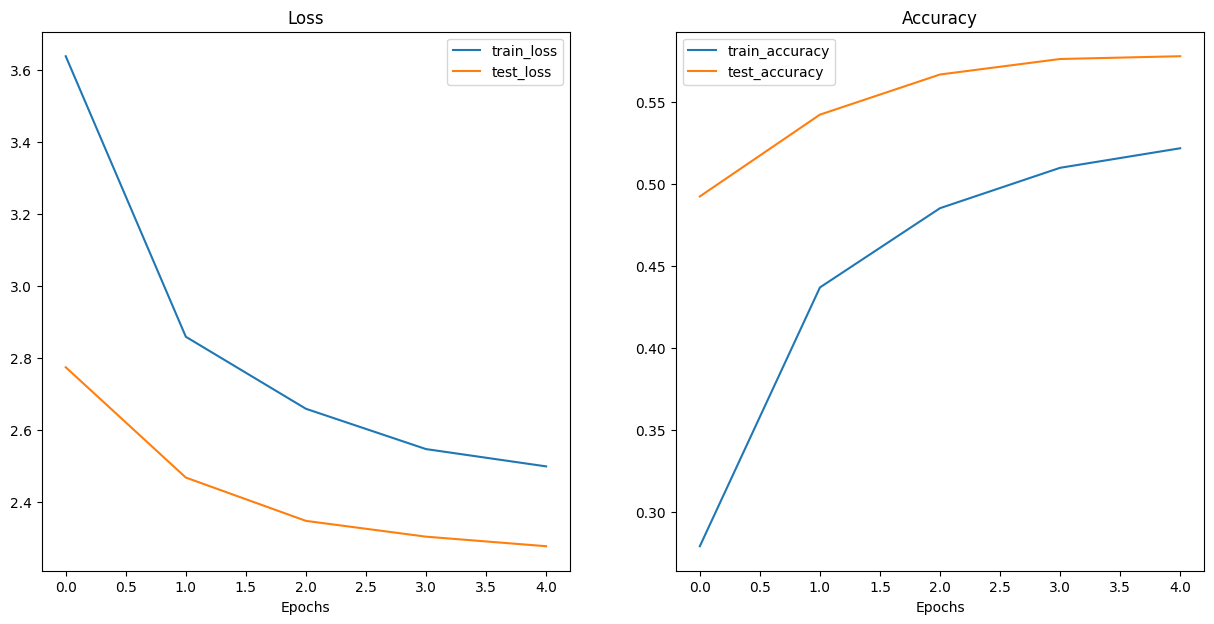

In [21]:
from src.plots import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)


## 6. Saving Food 101 Model

In [28]:
from src.modeling.utils import save_model
from src.config import MODEL_DIR

# Create a model path
effnetb2_food101_model_name = "effnetb2_food101_20_percent.pth"

In [29]:
# Save FoodVision Big model
save_model(
    model=effnetb2_food101,
    target_dir=MODEL_DIR,
    model_name=effnetb2_food101_model_name,
)


[INFO] Saving model to: models/effnetb2_food101_20_percent.pth


## 7. Save class names to txt file

In [31]:
# Save class names to a file
from pathlib import Path

class_names_path = Path("../references/food101_classes.txt")
class_names_path.parent.mkdir(parents=True, exist_ok=True)

with open(class_names_path, "w") as f:
    for class_name in food101_class_names:
        f.write(class_name + "\n")
